In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import warnings
import numpy as np
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.naive_bayes import GaussianNB
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## Importacion datos preprocesados de los resultados del notebook 2

In [5]:
# importamos dataframe ya preprocesado del notebook 02_preprocesado:
train = pd.read_csv("train_final.csv")
test  = pd.read_csv("test_final.csv")

X_train = train.drop(columns="target")
y_train = train["target"]

X_test  = test.drop(columns="target")
y_test  = test["target"]

In [6]:
# Confirmamos brevemente que la estructura del dataset importado sea correcto:
print(f"Numero de columas del dataset preprocesado con la seleccion de features {X_train.shape[1]}")
print(f"Numero de filas del dataframe completo: {X_train.shape[0]+X_test.shape[0]}")

Numero de columas del dataset preprocesado con la seleccion de features 11
Numero de filas del dataframe completo: 1215


In [7]:
X_train.describe()

,Unnamed: 0,high_risk_profile,financial_pressure,payment_behavior,status_account_no_checking_account,debt_to_income_ratio,duration,num_previous_loans,credit_history_critical_account,purpose_radio_television,credit_experience
count,972.000000,972.000000,972.000000,972.000000,972.000000,972.000000,9.720000e+02,972.000000,972.000000,972.000000,972.000000
mean,620.297325,0.163580,0.815387,2.419753,0.398148,0.266052,-9.503144e-17,2.495885,0.296296,0.272634,0.896091
std,360.076552,0.370085,0.751495,1.119411,0.489768,0.205460,1.000515e+00,1.686251,0.456858,0.445543,0.305300
min,0.000000,0.000000,0.031000,1.000000,0.000000,0.008000,-2.103326e+00,0.000000,0.000000,0.000000,0.000000
25%,308.750000,0.000000,0.247750,1.000000,0.000000,0.106000,-6.886576e-01,1.000000,0.000000,0.000000,1.000000
50%,616.000000,0.000000,0.517500,2.000000,0.000000,0.180000,5.676112e-03,2.000000,0.000000,0.000000,1.000000
75%,933.250000,0.000000,1.142500,3.000000,1.000000,0.473750,5.077999e-01,3.000000,1.000000,1.000000,1.000000
max,1248.000000,1.000000,3.940000,4.000000,1.000000,0.985000,2.139845e+00,9.000000,1.000000,1.000000,1.000000


In [8]:
y_test.value_counts()

target
1    170
0     73
Name: count, dtype: int64

In [9]:
y_train.value_counts()

target
1    680
0    292
Name: count, dtype: int64

## Modelo Regresion logistica

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

model = LogisticRegression()

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [11]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# 1) Pipeline: SMOTE se aplica SOLO al sub-train de cada fold
pipe = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=1000))
])

# 2) Espacio de búsqueda (nota el prefijo "model__")
param_grid = {
    "smote__k_neighbors": [3, 5, 7],
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"],
    "model__class_weight":[{0:5, 1:1}],  #Penalizamos mas los FP ya que nos cuestan mas
}

# 3) CV estratificada (puedes usar repetida si quieres más estabilidad)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# 4) GridSearch
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True  # al final re-entrena con los mejores hiperparámetros en TODO X_train
)

grid.fit(X_train, y_train)

print("Mejor score CV:", grid.best_score_)
print("Mejores params:", grid.best_params_)
best_model_Reg_log= grid.best_estimator_

Mejor score CV: 0.9963669336817136
Mejores params: {'model__C': 10, 'model__class_weight': {0: 5, 1: 1}, 'model__penalty': 'l2', 'model__solver': 'lbfgs', 'smote__k_neighbors': 7}


### Evaluamos el modelo con el conjunto TRAIN

In [12]:
# Resultados sobre el conjunto de entrenamiento
y_pred_train = best_model_Reg_log.predict(X_train)

##### Matriz de confusion en TRAIN


In [13]:
Rl_cm_train= confusion_matrix(y_train, y_pred_train)
Rl_cm_train

array([[289,   3],
       [ 22, 658]])

##### Accuracy en TRAIN

In [14]:
Rl_acc_train=accuracy_score(y_train, y_pred_train)

print(f"el acc del modelo es igual a {Rl_acc_train:.2f}")

el acc del modelo es igual a 0.97


##### Area bajo la curva (AUC)

In [15]:
# Métricas
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
fpr, tpr, threshold = roc_curve(y_train, y_pred_train)
Rl_roc_auc_train = roc_auc_score(y_train, y_pred_train)
Rl_f1_train=f1_score(y_train, y_pred_train)
Rl_precision_train=precision_score(y_train, y_pred_train)
Rl_recall_train=recall_score(y_train, y_pred_train)

print(f" roc_auc es igual a: {Rl_roc_auc_train:.2f}")      
print(f" f1 es igual a: {Rl_f1_train:.2f}")
print(f" precision es igual a: {Rl_precision_train:.2f}")
print(f" recall es igual a: {Rl_recall_train:.2f}")

 roc_auc es igual a: 0.98
 f1 es igual a: 0.98
 precision es igual a: 1.00
 recall es igual a: 0.97


In [16]:
fpr, tpr, threshold = roc_curve(y_train, y_pred_train)
Rl_roc_auc_train = roc_auc_score(y_train, y_pred_train)

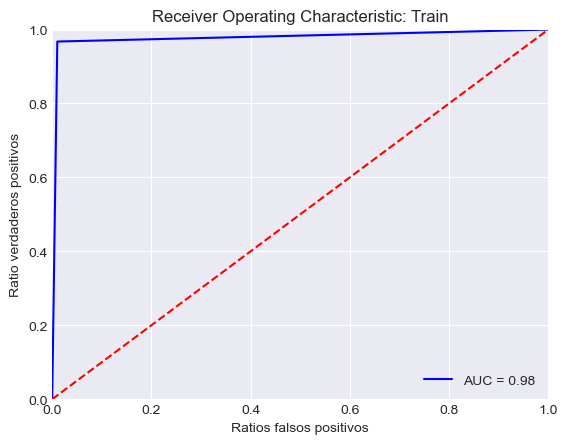

In [17]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: Train')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % Rl_roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

### Evaluacion del modelo con el Conjunto de TEST


In [18]:
y_pred_test=best_model_Reg_log.predict(X_test)
y_prob_test=best_model_Reg_log.predict_proba(X_test)[:,1]

##### Matriz de confusion en TEST


In [19]:
Rl_cm_test=confusion_matrix(y_test, y_pred_test)
Rl_cm_test

array([[ 72,   1],
       [  7, 163]])

##### Evaluacion de costos en TEST


In [20]:
tn, fp, fn, tp = Rl_cm_test.ravel()

Rl_total_cost = 5*fp + 1*fn
print("Costo total:", Rl_total_cost)

Costo total: 12


##### Accuracy en TEST

In [21]:
Rl_acc_test=accuracy_score(y_test, y_pred_test)
print(f"el acc del modelo es igual a {Rl_acc_test:.2f}")

el acc del modelo es igual a 0.97


##### Area bajo la curva (AUC) & otras Metricas en TEST

In [22]:
# Métricas
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
fpr, tpr, threshold = roc_curve(y_test, y_pred_test)
Rl_roc_auc_test = roc_auc_score(y_test, y_pred_test)
Rl_f1_test=f1_score(y_test, y_pred_test)
Rl_precision_test=precision_score(y_test, y_pred_test)
Rl_recall_test=recall_score(y_test, y_pred_test)

print(f" roc_auc es igual a: {Rl_roc_auc_test:.2f}")      
print(f" f1 es igual a: {Rl_f1_test:.2f}")
print(f" precision es igual a: {Rl_precision_test:.2f}")
print(f" recall es igual a: {Rl_recall_test:.2f}")


 roc_auc es igual a: 0.97
 f1 es igual a: 0.98
 precision es igual a: 0.99
 recall es igual a: 0.96


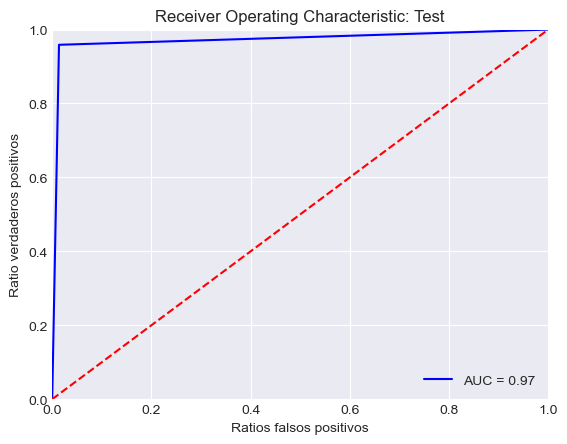

In [23]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: Test')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % Rl_roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

#### Consolidacion de resultados del modelo de regresion logistica

In [24]:
Rl_resultados={
    "cm":Rl_cm_test.ravel().tolist(),
    "acc":round(Rl_acc_test,2),
    "roc_auc":round(Rl_roc_auc_test,2),
    "f1":round(Rl_f1_test,2),
    "precision":round(Rl_precision_test,2),
    "recall":round(Rl_recall_test,2),
    "costos_totales":int(Rl_total_cost)
}
Rl_resultados



{'cm': [72, 1, 7, 163],
 'acc': 0.97,
 'roc_auc': 0.97,
 'f1': 0.98,
 'precision': 0.99,
 'recall': 0.96,
 'costos_totales': 12}

## Modelo NAIVE BAYES

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

gnb = GaussianNB()

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [26]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# 1) Pipeline: SMOTE se aplica SOLO al sub-train de cada fold
pipe = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("model", GaussianNB())
])

# 2) Espacio de búsqueda (nota el prefijo "model__")
param_grid = {
    "smote__sampling_strategy": [0.5, 0.75, 1.0],
    "smote__k_neighbors": [3, 5, 7],
    "model__var_smoothing": [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6],
    "model__priors":[[0.7, 0.3]],  #Ser mas conservador con la clasificacion de un cliente como bueno (1)
    # Opcional:
    # "model__cl": [None, [0.8, 0.2], [0.9, 0.1]]
}

# 3) CV estratificada (puedes usar repetida si quieres más estabilidad)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# 4) GridSearch
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True  # al final re-entrena con los mejores hiperparámetros en TODO X_train
)

grid.fit(X_train, y_train)

print("Mejor score CV:", grid.best_score_)
print("Mejores params:", grid.best_params_)
best_model_Nav_Bayes= grid.best_estimator_

Mejor score CV: 0.9963362068965518
Mejores params: {'model__priors': [0.7, 0.3], 'model__var_smoothing': 1e-10, 'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.75}


### Evaluamos el modelo con el conjunto de entrenamiento

In [27]:
# Resultados sobre el conjunto de entrenamiento
y_pred_train = best_model_Nav_Bayes.predict(X_train)

##### Matriz de confusion


In [28]:
Nv_cm_train = confusion_matrix(y_train, y_pred_train)
Nv_cm_train

array([[287,   5],
       [ 11, 669]])

##### Accuracy

In [29]:
Nv_acc_train=accuracy_score(y_train, y_pred_train)

print(f"el acc del modelo es igual a {Nv_acc_train:.2f}")

el acc del modelo es igual a 0.98


##### Area bajo la curva (AUC)

In [30]:
# Métricas
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
fpr, tpr, threshold = roc_curve(y_train, y_pred_train)
Nv_roc_auc = roc_auc_score(y_train, y_pred_train)
Nv_f1=f1_score(y_train, y_pred_train)
Nv_precision=precision_score(y_train, y_pred_train)
Nv_recall=recall_score(y_train, y_pred_train)

print(f" roc_auc es igual a: {Nv_roc_auc :.2f}")      
print(f" f1 es igual a: {Nv_f1:.2f}")
print(f" precision es igual a: {Nv_precision:.2f}")
print(f" recall es igual a: {Nv_recall:.2f}")

 roc_auc es igual a: 0.98
 f1 es igual a: 0.99
 precision es igual a: 0.99
 recall es igual a: 0.98


In [31]:
fpr, tpr, threshold = roc_curve(y_train, y_pred_train)
Nv_roc_auc = roc_auc_score(y_train, y_pred_train)

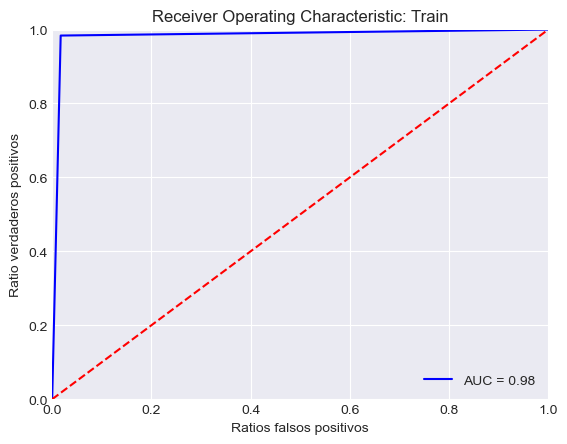

In [32]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: Train')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % Nv_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

### Evaluacion del modelo en el Conjunto de Testing


In [33]:
y_pred_test=best_model_Nav_Bayes.predict(X_test)
y_prob_test=best_model_Nav_Bayes.predict_proba(X_test)[:,1]

##### Matriz de confusion en Test


In [34]:
Nv_cm_test=confusion_matrix(y_test, y_pred_test)
Nv_cm_test

array([[ 72,   1],
       [  5, 165]])

#### Calculo de costos

In [35]:
tn, fp, fn, tp =Nv_cm_test.ravel()

Nv_total_cost= fp*5 + fn

print(f"Costo total: {Nv_total_cost}")

Costo total: 10


##### Accuracy en TEST

In [36]:
Nv_acc_test=accuracy_score(y_test, y_pred_test)
print(f"el acc del modelo es igual a {Nv_acc_test:.2f}")

el acc del modelo es igual a 0.98


##### Area bajo la curva (AUC) en TEST

In [37]:
# Métricas
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
fpr, tpr, threshold = roc_curve(y_test, y_pred_test)
Nv_roc_auc_test = roc_auc_score(y_test, y_pred_test)
Nv_f1_test=f1_score(y_test, y_pred_test)
Nv_precision_test=precision_score(y_test, y_pred_test)
Nv_recall_test=recall_score(y_test, y_pred_test)

print(f" roc_auc es igual a: {Nv_roc_auc_test:.2f}")      
print(f" f1 es igual a: {Nv_f1_test:.2f}")
print(f" precision es igual a: {Nv_precision_test:.2f}")
print(f" recall es igual a: {Nv_recall_test:.2f}")


 roc_auc es igual a: 0.98
 f1 es igual a: 0.98
 precision es igual a: 0.99
 recall es igual a: 0.97


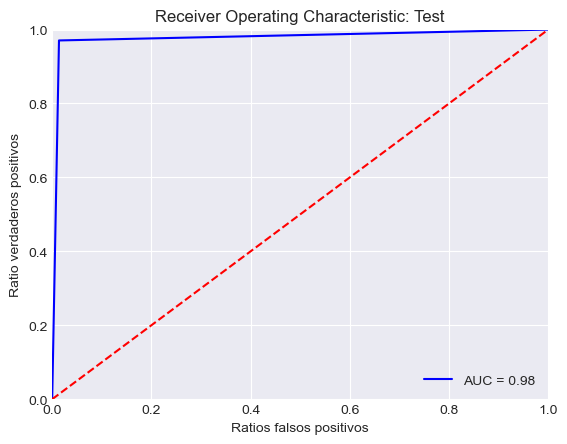

In [38]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: Test')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % Nv_roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

#### Consolidacion de resultados en modelo Naive Bayes

In [39]:
Nv_resultados = {
    "cm": Nv_cm_test.ravel().tolist(),
    "acc": round(Nv_acc_test, 2),
    "roc_auc": round(Nv_roc_auc_test, 2),
    "f1": round(Nv_f1_test, 2),
    "precision": round(Nv_precision_test, 2),
    "recall": round(Nv_recall_test, 2),
    "costos_totales": int(Nv_total_cost)
}

Nv_resultados

{'cm': [72, 1, 5, 165],
 'acc': 0.98,
 'roc_auc': 0.98,
 'f1': 0.98,
 'precision': 0.99,
 'recall': 0.97,
 'costos_totales': 10}

## Modelo de clasificacion por arboles de decision DTC

In [40]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 1) Pipeline: SMOTE se aplica SOLO al sub-train de cada fold
pipe = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("model", DecisionTreeClassifier(random_state=42))
])

# 2) Espacio de búsqueda (nota el prefijo "model__")
param_grid = {
    "smote__sampling_strategy": [0.5, 0.75, 1.0],
    "smote__k_neighbors": [3, 5, 7],
    "model__max_depth": [3, 5, 7, 10, 15],
    "model__min_samples_leaf": [5, 10, 20, 50],
    "model__min_samples_split": [10, 20, 50],
    "model__max_features": [None, "sqrt", "log2"],
    "model__criterion": ["gini", "entropy"],
    "model__class_weight":[{0:5, 1:1}], #Los errores sobre la clase 0 pesan 5× más
}

# 3) CV estratificada (puedes usar repetida si quieres más estabilidad)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# 4) GridSearch
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True  # al final re-entrena con los mejores hiperparámetros en TODO X_train
)

grid.fit(X_train, y_train)

print("Mejor score CV:", grid.best_score_)
print("Mejores params:", grid.best_params_)
best_model_Dtc= grid.best_estimator_

Mejor score CV: 0.9982890767353112
Mejores params: {'model__class_weight': {0: 5, 1: 1}, 'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_leaf': 20, 'model__min_samples_split': 10, 'smote__k_neighbors': 7, 'smote__sampling_strategy': 0.5}


### Prediccion del modelo sobre datos de entrenamiento

In [41]:
y_train_pred=best_model_Dtc.predict(X_train) 

##### Matriz de confusion en Train


In [42]:
Dtc_cm_train= confusion_matrix(y_train, y_pred_train)
Dtc_cm_train

array([[287,   5],
       [ 11, 669]])

##### Accuracy en Train

In [43]:
Dtc_acc_train=accuracy_score(y_train, y_pred_train)

print(f"el acc del modelo es igual a {Dtc_acc_train:.2f}")

el acc del modelo es igual a 0.98


##### Area bajo la curva (AUC) en Train

In [44]:
# Métricas
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
fpr, tpr, threshold = roc_curve(y_train, y_pred_train)
Dtc_roc_auc_train = roc_auc_score(y_train, y_pred_train)
Dtc_f1_train=f1_score(y_train, y_pred_train)
Dtc_precision_train=precision_score(y_train, y_pred_train)
Dtc_recall_train=recall_score(y_train, y_pred_train)

print(f" roc_auc es igual a: {Dtc_roc_auc_train:.2f}")      
print(f" f1 es igual a: {Dtc_f1_train:.2f}")
print(f" precision es igual a: {Dtc_precision_train:.2f}")
print(f" recall es igual a: {Dtc_recall_train:.2f}")

 roc_auc es igual a: 0.98
 f1 es igual a: 0.99
 precision es igual a: 0.99
 recall es igual a: 0.98


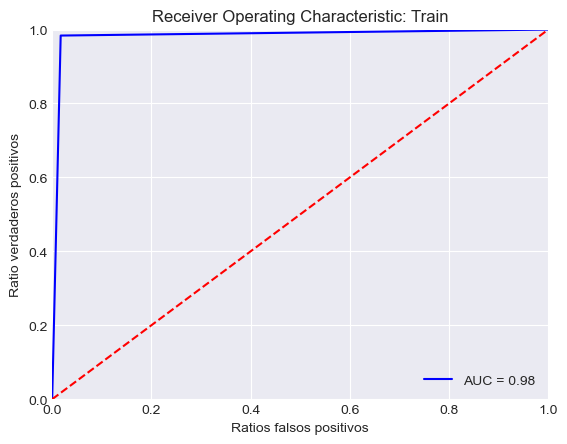

In [45]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: Train')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % Dtc_roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

### Evaluamos el modelo con el conjunto de evaluacion

In [46]:
# Resultados sobre el conjunto de test
y_pred_test = best_model_Dtc.predict(X_test)
y_prob_test=best_model_Dtc.predict_proba(X_test)[:,1]

##### Matriz de confusion en test


In [47]:
Dtc_cm_test= confusion_matrix(y_test, y_pred_test)
Dtc_cm_test

array([[ 73,   0],
       [  6, 164]])

#### Calcular matriz de costos

In [48]:
tn, fp, fn, tp =Nv_cm_test.ravel()

Dtc_total_cost= fp*5 + fn

print(f"Costo total: {Dtc_total_cost}")

Costo total: 10


##### Accuracy en test

In [49]:
Dtc_acc_test=accuracy_score(y_test, y_pred_test)

print(f"el acc del modelo es igual a {Dtc_acc_test:.2f}")

el acc del modelo es igual a 0.98


##### Area bajo la curva (AUC) en test

In [50]:
# Métricas TEST
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    accuracy_score, confusion_matrix,
    f1_score, precision_score, recall_score
)

fpr, tpr, threshold = roc_curve(y_test, y_pred_test)

Dtc_roc_auc_test = roc_auc_score(y_test, y_pred_test)
Dtc_f1_test = f1_score(y_test, y_pred_test)
Dtc_precision_test = precision_score(y_test, y_pred_test)
Dtc_recall_test = recall_score(y_test, y_pred_test)

print(f" roc_auc es igual a: {Dtc_roc_auc_test:.2f}")      
print(f" f1 es igual a: {Dtc_f1_test:.2f}")
print(f" precision es igual a: {Dtc_precision_test:.2f}")
print(f" recall es igual a: {Dtc_recall_test:.2f}")

 roc_auc es igual a: 0.98
 f1 es igual a: 0.98
 precision es igual a: 1.00
 recall es igual a: 0.96


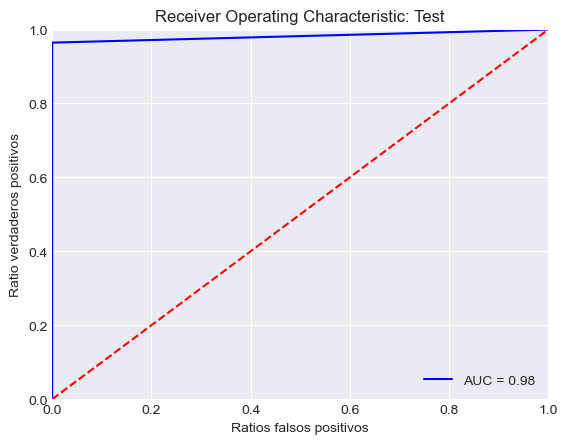

In [51]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: Test')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % Dtc_roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

#### Consolidacion de resultados en diccionario

In [52]:
Dtc_resultados = {
    "cm": Dtc_cm_test.ravel().tolist(),
    "acc": round(Dtc_acc_test, 2),
    "roc_auc": round(Dtc_roc_auc_test, 2),
    "f1": round(Dtc_f1_test, 2),
    "precision": round(Dtc_precision_test, 2),
    "recall": round(Dtc_recall_test, 2),
    "costos_totales": int(Dtc_total_cost)
}

Dtc_resultados

{'cm': [73, 0, 6, 164],
 'acc': 0.98,
 'roc_auc': 0.98,
 'f1': 0.98,
 'precision': 1.0,
 'recall': 0.96,
 'costos_totales': 10}

## Modelo Random Forrest 

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [54]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

# 1) Pipeline: SMOTE se aplica SOLO al sub-train de cada fold
pipe = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(random_state=42))
])

# 2) Espacio de búsqueda (nota el prefijo "model__")
param_grid = {
    "smote__sampling_strategy": [0.75, 1.0],
    "smote__k_neighbors": [3, 5],
    "model__n_estimators": [200, 400],
    "model__max_depth": [5, 10, None],
    "model__min_samples_leaf": [5, 10,],
    "model__min_samples_split": [10, 20],
    "model__class_weight": [{0:5, 1:1}],
}

# 3) CV estratificada (puedes usar repetida si quieres más estabilidad)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# 4) GridSearch
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True  # al final re-entrena con los mejores hiperparámetros en TODO X_train
)

grid.fit(X_train, y_train)

print("Mejor score CV:", grid.best_score_)
print("Mejores params:", grid.best_params_)
best_model_rf= grid.best_estimator_

Mejor score CV: 0.9981318974112146
Mejores params: {'model__class_weight': {0: 5, 1: 1}, 'model__max_depth': 5, 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200, 'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.75}


#### Evaluacion en datos de TRAIN

In [55]:
y_pred_train=best_model_rf.predict(X_train)
y_prob_train=best_model_rf.predict_proba(X_train)

#### Matriz de confusion para TRAIN

In [56]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
rf_cm_train=confusion_matrix(y_train, y_pred_train)
rf_cm_train

array([[290,   2],
       [ 11, 669]])

#### calculamos accuracy para TRAIN

In [57]:
rf_acc_train=accuracy_score(y_train, y_pred_train)
print(f"El accuracy de train es igual a : {rf_acc_train:.2f}")

El accuracy de train es igual a : 0.99


#### Area bajo la curva en TRAIN

In [58]:
# Métricas
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
fpr, tpr, threshold = roc_curve(y_train, y_pred_train)
rf_roc_auc_train = roc_auc_score(y_train, y_pred_train)
rf_f1_train=f1_score(y_train, y_pred_train)
rf_precision_train=precision_score(y_train, y_pred_train)
rf_recall_train=recall_score(y_train, y_pred_train)

print(f" roc_auc es igual a: {rf_roc_auc_train:.2f}")      
print(f" f1 es igual a: {rf_f1_train:.2f}")
print(f" precision es igual a: {rf_precision_train:.2f}")
print(f" recall es igual a: {rf_recall_train:.2f}")

 roc_auc es igual a: 0.99
 f1 es igual a: 0.99
 precision es igual a: 1.00
 recall es igual a: 0.98


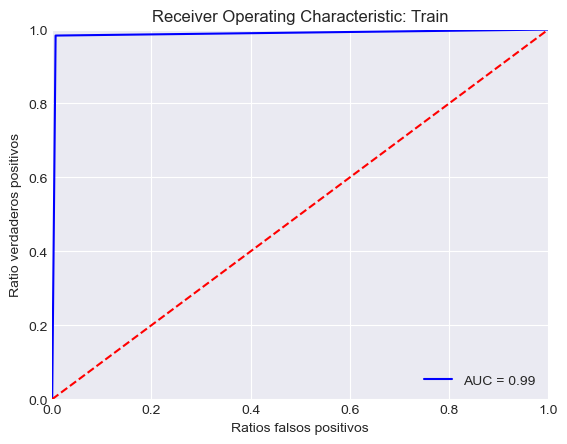

In [59]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: Train')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % rf_roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

#### Evaluacion del modelo RF con TEST

In [60]:
y_pred_test=best_model_rf.predict(X_test)
y_prob_test=best_model_rf.predict_proba(X_test)[:,1]

#### Evaluamos matriz de confusion en TEST

In [61]:
#Matriz de confusion
rf_cm_test= confusion_matrix(y_test, y_pred_test)
rf_cm_test

array([[ 72,   1],
       [  6, 164]])

In [62]:
#### Calculo del costo total del modelo 

tn, fp, fn, tp = rf_cm_test.ravel()

rf_total_cost = 5*fp + 1*fn
print("Costo total:", rf_total_cost)

Costo total: 11


#### Evaluamos accuracy en TEST


In [63]:
rf_acc_test=accuracy_score(y_test, y_pred_test)
print(f"El accuracy en test es igual a : {rf_acc_test:.2f}")

El accuracy en test es igual a : 0.97


#### Calculamos Area bajo la curva (AUC) & otras metricas TEST

In [64]:
# AUC & Métricas 
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
fpr, tpr, threshold = roc_curve(y_test, y_pred_test)
rf_roc_auc_test = roc_auc_score(y_test, y_pred_test)
rf_f1_test = f1_score(y_test, y_pred_test)
rf_precision_test = precision_score(y_test, y_pred_test)
rf_recall_test = recall_score(y_test, y_pred_test)

print(f" roc_auc es igual a: {rf_roc_auc_test:.2f}")      
print(f" f1 es igual a: {rf_f1_test:.2f}")
print(f" precision es igual a: {rf_precision_test:.2f}")
print(f" recall es igual a: {rf_recall_test:.2f}")

 roc_auc es igual a: 0.98
 f1 es igual a: 0.98
 precision es igual a: 0.99
 recall es igual a: 0.96


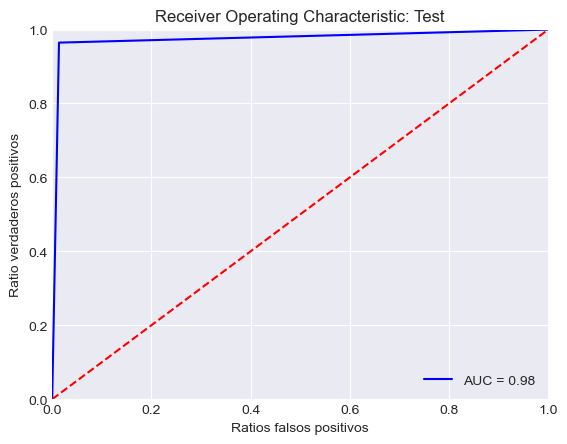

In [65]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: Test')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % rf_roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

#### Consolidamos todos los resultados del modelo Random forrest

In [66]:
rf_resultados = {
    "cm": rf_cm_test.ravel().tolist(),
    "acc": round(rf_acc_test, 2),
    "roc_auc": round(rf_roc_auc_test, 2),
    "f1": round(rf_f1_test, 2),
    "precision": round(rf_precision_test, 2),
    "recall": round(rf_recall_test, 2),
    "costos_totales": int(rf_total_cost)
}

rf_resultados

{'cm': [72, 1, 6, 164],
 'acc': 0.97,
 'roc_auc': 0.98,
 'f1': 0.98,
 'precision': 0.99,
 'recall': 0.96,
 'costos_totales': 11}

## Modelo XGBoost

In [67]:
from xgboost import XGBClassifier


In [68]:
## Importamos algoritmos para poder utilizar XGboost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold


# 1) Pipeline: SMOTE se aplica SOLO al sub-train de cada fold
pipe=Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("model", XGBClassifier())
])

# 2) CV estratificada (puedes usar repetida si quieres más estabilidad)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# 3) Espacio de búsqueda
param_grid = {
    # SMOTE (pocos valores para no explotar el grid)
    "smote__sampling_strategy": [0.75, 1.0],
    "smote__k_neighbors": [3, 5],

    # XGBoost hiperparametros
    "model__n_estimators": [300, 600],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5],
    "model__min_child_weight": [1, 5],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__reg_lambda": [1, 5],
}

# 4) GridSearch
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True  # al final re-entrena con los mejores hiperparámetros en TODO X_train
)

grid.fit(X_train, y_train)

print("Mejor score CV:", grid.best_score_)
print("Mejores params:", grid.best_params_)
best_model_Xgb= grid.best_estimator_

Mejor score CV: 0.9990025612816723
Mejores params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__n_estimators': 600, 'model__reg_lambda': 5, 'model__subsample': 1.0, 'smote__k_neighbors': 5, 'smote__sampling_strategy': 1.0}


#### Evaluación del modelo con conjunto de entrenamiento
 

In [69]:
y_pred_train=best_model_Xgb.predict(X_train)


#### Evaluamos matriz de confusion para TRAIN

In [70]:
xgb_cm_train=confusion_matrix(y_train, y_pred_train)
xgb_cm_train

array([[292,   0],
       [  1, 679]])

#### Evaluamos Accuracy con Train

In [71]:
xgb_acc_train=accuracy_score(y_train, y_pred_train)
print(F"el acc con TRAIN es igual a:{xgb_acc_train:.3f}")

el acc con TRAIN es igual a:0.999


#### Evaluacion area bajo la curva y otras metricas con TRAIN

In [72]:
# AUC & demás Métricas 
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

fpr, tpr, threshold = roc_curve(y_train, y_pred_train)
xgb_roc_auc_train = roc_auc_score(y_train, y_pred_train)
xgb_f1_train = f1_score(y_train, y_pred_train)
xgb_precision_train = precision_score(y_train, y_pred_train)
xgb_recall_train = recall_score(y_train, y_pred_train)

print(f" roc_auc es igual a: {xgb_roc_auc_train:.2f}")      
print(f" f1 es igual a: {xgb_f1_train:.2f}")
print(f" precision es igual a: {xgb_precision_train:.2f}")
print(f" recall es igual a: {xgb_recall_train:.2f}")

 roc_auc es igual a: 1.00
 f1 es igual a: 1.00
 precision es igual a: 1.00
 recall es igual a: 1.00


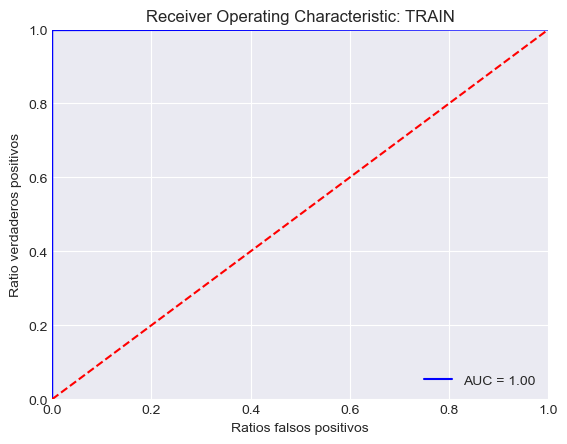

In [73]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: TRAIN')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % xgb_roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

#### Evaluacion del modelo con datos de evaluacion TEST

In [74]:
y_pred_test=best_model_Xgb.predict(X_test)
y_pred_prob=best_model_Xgb.predict_proba(X_test)

#### Evaluamos la matriz de confusion en TEST

In [75]:
xgb_cm_test=confusion_matrix(y_test, y_pred_test)
xgb_cm_test

array([[ 73,   0],
       [  2, 168]])

#### Evaluamos matriz de costos en TEST


In [76]:
tn, fp, fn, tp=xgb_cm_test.ravel()

xgb_total_cost=fn*1+fp*5

print(f"El costo total es igual: {xgb_total_cost}")

El costo total es igual: 2


#### Evaluamos ACC con Test

In [77]:
xgb_acc_test=accuracy_score(y_test, y_pred_test)
print(F"El valor de accuracy para test es igual a: {xgb_acc_test:.3F} ")

El valor de accuracy para test es igual a: 0.992 


#### Area bajo la curva (AUC) & demás métricas para TEST


In [78]:
# AUC & demás Métricas 
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

fpr, tpr, threshold = roc_curve(y_test, y_pred_test)
xgb_roc_auc_test = roc_auc_score(y_test, y_pred_test)
xgb_f1_test = f1_score(y_test, y_pred_test)
xgb_precision_test = precision_score(y_test, y_pred_test)
xgb_recall_test = recall_score(y_test, y_pred_test)

print(f" roc_auc es igual a: {xgb_roc_auc_test:.2f}")      
print(f" f1 es igual a: {xgb_f1_test:.2f}")
print(f" precision es igual a: {xgb_precision_test:.2f}")
print(f" recall es igual a: {xgb_recall_test:.2f}")

 roc_auc es igual a: 0.99
 f1 es igual a: 0.99
 precision es igual a: 1.00
 recall es igual a: 0.99


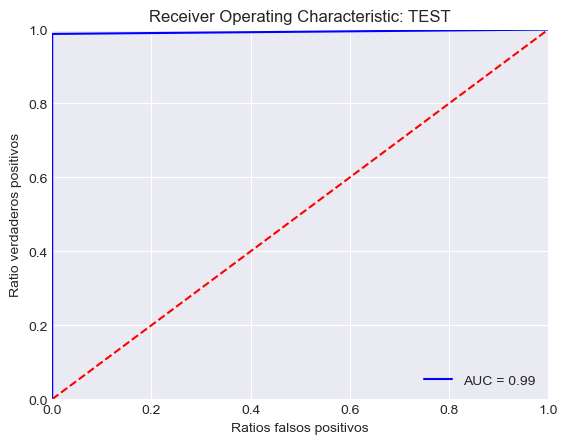

In [79]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: TEST')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % xgb_roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

#### Consolidación de resultados con modelo XGB

In [80]:
xgb_resultados = {
    "cm": xgb_cm_test.ravel().tolist(),
    "acc": round(xgb_acc_test, 2),
    "roc_auc": round(xgb_roc_auc_test, 2),
    "f1": round(xgb_f1_test, 2),
    "precision": round(xgb_precision_test, 2),
    "recall": round(xgb_recall_test, 2),
    "costos_totales": int(xgb_total_cost)
}

xgb_resultados

{'cm': [73, 0, 2, 168],
 'acc': 0.99,
 'roc_auc': 0.99,
 'f1': 0.99,
 'precision': 1.0,
 'recall': 0.99,
 'costos_totales': 2}

## Modelo SVM con kernel lineal

In [167]:
## Modelo svm con kernel lineal o rbf

## Importamos algoritmos para poder utilizar Support vector classifier (SVC)
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# 1) Pipeline: SMOTE se aplica SOLO al sub-train de cada fold
pipe=Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("svc", SVC(random_state=42))
])

# 2) CV estratificada (puedes usar repetida si quieres más estabilidad)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# 3) Espacio de búsqueda
param_grid = [
    {
        # SVM con kernel LINEAL
        "svc__kernel": ["linear"],
        "svc__C": [0.1, 1],
        "svc__class_weight": [{0:5,1:1}],  #FP 5 vs FN 1 castigar 5 veces mas errores en clase 0

        # SMOTE
        "smote__sampling_strategy": [0.75, 1.0],
        "smote__k_neighbors": [3, 5]
    },

]

# 4) GridSearch
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True  # al final re-entrena con los mejores hiperparámetros en TODO X_train
)

grid.fit(X_train, y_train)

print("Mejor score CV:", grid.best_score_)
print("Mejores params:", grid.best_params_)
best_model_svc_lineal= grid.best_estimator_

Mejor score CV: 0.9962440265410665
Mejores params: {'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.75, 'svc__C': 1, 'svc__class_weight': {0: 5, 1: 1}, 'svc__kernel': 'linear'}


In [168]:
#### Evaluacion del modelo con conjunto de entrenamiento TRAIN
y_pred_train=best_model_svc_lineal.predict(X_train)


In [169]:
#### Evaluacion matriz de confusion TRAIN
svc_lineal_cm_train=confusion_matrix(y_train, y_pred_train)
svc_lineal_cm_train

array([[290,   2],
       [ 26, 654]])

In [170]:
#### Evaluamos accuracy en TRAIN
svc_lineal_acc_train=accuracy_score(y_train, y_pred_train)

In [171]:
#### Area bajo la curva (auc) & demás métricas
# AUC & demás Métricas 
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

fpr, tpr, threshold = roc_curve(y_train, y_pred_train)
svc_lineal_roc_auc_train = roc_auc_score(y_train, y_pred_train)
svc_lineal_f1_train = f1_score(y_train, y_pred_train)
svc_lineal_precision_train = precision_score(y_train, y_pred_train)
svc_lineal_recall_train = recall_score(y_train, y_pred_train)

print(f" roc_auc es igual a: {svc_lineal_roc_auc_train:.2f}")      
print(f" f1 es igual a: {svc_lineal_f1_train:.2f}")
print(f" precision es igual a: {svc_lineal_precision_train:.2f}")
print(f" recall es igual a: {svc_lineal_recall_train:.2f}")

 roc_auc es igual a: 0.98
 f1 es igual a: 0.98
 precision es igual a: 1.00
 recall es igual a: 0.96


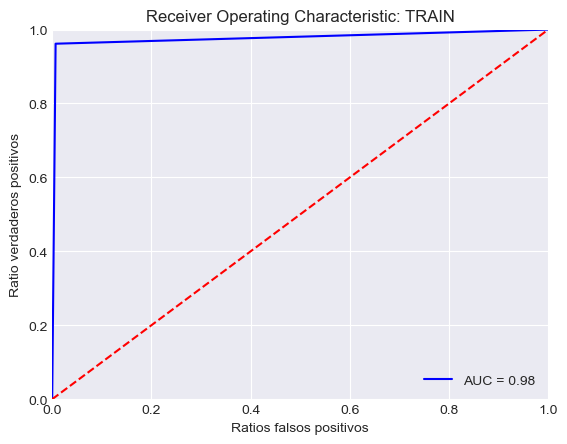

In [172]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: TRAIN')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % svc_lineal_roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

#### Evaluacion de modelo en conjunto TEST

In [173]:
y_pred_test=best_model_svc_lineal.predict(X_test)


#### Matriz de confusion para TEST

In [174]:
#### Matriz de confusion con TEST
from sklearn.metrics import confusion_matrix
svc_lineal_cm_test=confusion_matrix(y_test, y_pred_test)
svc_lineal_cm_test

array([[ 72,   1],
       [  8, 162]])

#### Evaluacion Matriz de costos en TEST

In [175]:
tn, fp, fn, tp =svc_lineal_cm_test.ravel()

svc_lineal_total_cost=1*fn+5*fp 

print(f"El costo total es igual a : {svc_lineal_total_cost}")

El costo total es igual a : 13


#### Accuracy para Test

In [176]:
svc_lineal_acc_test=accuracy_score(y_test, y_pred_test)
print(f"El accuracy para test es igual a: {svc_lineal_acc_test:.2f}")

El accuracy para test es igual a: 0.96


In [139]:
#### Area bajo la curva (auc) & demás métricas
# AUC & demás Métricas 
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

fpr, tpr, threshold = roc_curve(y_test, y_pred_test)
svc_lineal_roc_auc_test = roc_auc_score(y_test, y_pred_test)
svc_lineal_f1_test = f1_score(y_test, y_pred_test)
svc_lineal_precision_test = precision_score(y_test, y_pred_test)
svc_lineal_recall_test = recall_score(y_test, y_pred_test)

print(f" roc_auc es igual a: {svc_lineal_roc_auc_test:.2f}")      
print(f" f1 es igual a: {svc_lineal_f1_test:.2f}")
print(f" precision es igual a: {svc_lineal_precision_test:.2f}")
print(f" recall es igual a: {svc_lineal_recall_test:.2f}")

 roc_auc es igual a: 0.97
 f1 es igual a: 0.97
 precision es igual a: 0.99
 recall es igual a: 0.95


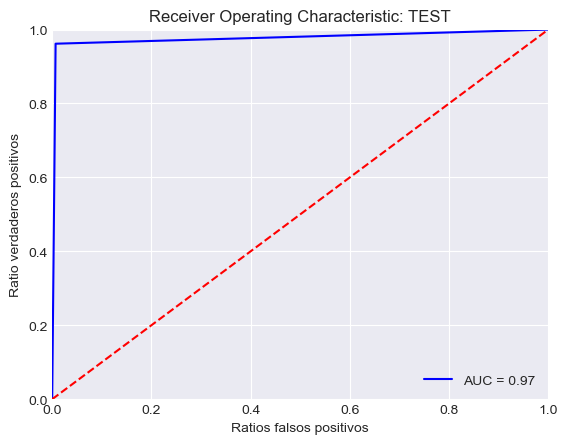

In [177]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: TEST')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % svc_lineal_roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

#### Consolidacion de los resultados del modelo SVC LINEAL

In [178]:
svc_lineal_resultados = {
    "cm": svc_lineal_cm_test.ravel().tolist(),
    "acc": round(svc_lineal_acc_test, 2),
    "roc_auc": round(svc_lineal_roc_auc_test, 2),
    "f1": round(svc_lineal_f1_test, 2),
    "precision": round(svc_lineal_precision_test, 2),
    "recall": round(svc_lineal_recall_test, 2),
    "costos_totales": int(svc_lineal_total_cost)
}

svc_lineal_resultados

{'cm': [72, 1, 8, 162],
 'acc': 0.96,
 'roc_auc': 0.97,
 'f1': 0.97,
 'precision': 0.99,
 'recall': 0.95,
 'costos_totales': 13}

## Modelo SVM con  kernel RBF

In [181]:
## Modelo svm con kernel lineal o rbf

## Importamos algoritmos para poder utilizar Support vector classifier (SVC)
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# 1) Pipeline: SMOTE se aplica SOLO al sub-train de cada fold
pipe=Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("svc", SVC(random_state=42))
])

# 2) CV estratificada (puedes usar repetida si quieres más estabilidad)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# 3) Espacio de búsqueda
param_grid = [
    {
        # SVM con kernel rbf
        "svc__kernel": ["rbf"],
        "svc__gamma": ["scale", 0.01, 0.1, 1],
        "svc__C": [0.1, 1,10],
        "svc__class_weight": [{0:5,1:1}],  #FP 5 vs FN 1 castigar 5 veces mas errores en clase 0

        # SMOTE
        "smote__sampling_strategy": [0.75, 1.0],
        "smote__k_neighbors": [3, 5]
    },

]

# 4) GridSearch
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True  # al final re-entrena con los mejores hiperparámetros en TODO X_train
)

grid.fit(X_train, y_train)

print("Mejor score CV:", grid.best_score_)
print("Mejores params:", grid.best_params_)
best_model_svc_rbf= grid.best_estimator_

Mejor score CV: 0.9707867775982398
Mejores params: {'smote__k_neighbors': 3, 'smote__sampling_strategy': 1.0, 'svc__C': 1, 'svc__class_weight': {0: 5, 1: 1}, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


In [185]:
#### Evaluacion del modelo con conjunto de entrenamiento TRAIN
y_pred_train=best_model_svc_rbf.predict(X_train)


In [186]:
#### Evaluacion matriz de confusion TRAIN
svc_rbf_cm_train=confusion_matrix(y_train, y_pred_train)
svc_rbf_cm_train

array([[292,   0],
       [680,   0]])

In [187]:
#### Evaluamos accuracy en TRAIN
svc_rbf_acc_train=accuracy_score(y_train, y_pred_train)

In [188]:
#### Area bajo la curva (auc) & demás métricas
# AUC & demás Métricas 
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

fpr, tpr, threshold = roc_curve(y_train, y_pred_train)
svc_rbf_roc_auc_train = roc_auc_score(y_train, y_pred_train)
svc_rbf_f1_train = f1_score(y_train, y_pred_train)
svc_rbf_precision_train = precision_score(y_train, y_pred_train)
svc_rbf_recall_train = recall_score(y_train, y_pred_train)

print(f" roc_auc es igual a: {svc_rbf_roc_auc_train:.2f}")      
print(f" f1 es igual a: {svc_rbf_f1_train:.2f}")
print(f" precision es igual a: {svc_rbf_precision_train:.2f}")
print(f" recall es igual a: {svc_rbf_recall_train:.2f}")

 roc_auc es igual a: 0.50
 f1 es igual a: 0.00
 precision es igual a: 0.00
 recall es igual a: 0.00


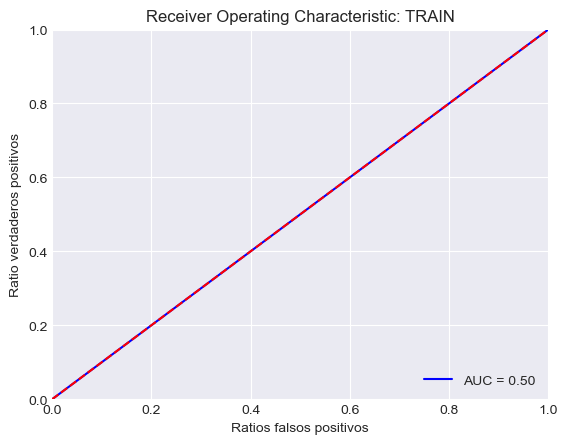

In [189]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: TRAIN')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % svc_rbf_roc_auc_train)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

#### Evaluacion de modelo en conjunto TEST

In [191]:
y_pred_test=best_model_svc_rbf.predict(X_test)


#### Matriz de confusion para TEST

In [192]:
#### Matriz de confusion con TEST
from sklearn.metrics import confusion_matrix
svc_rbf_cm_test=confusion_matrix(y_test, y_pred_test)
svc_rbf_cm_test

array([[ 73,   0],
       [170,   0]])

#### Evaluacion Matriz de costos en TEST

In [202]:
tn, fp, fn, tp =svc_rbf_cm_test.ravel()

svc_rbf_total_cost=1*fn+5*fp 

print(f"El costo total es igual a : {svc_rbf_total_cost}")

El costo total es igual a : 170


#### Accuracy para Test

In [203]:
svc_rbf_acc_test=accuracy_score(y_test, y_pred_test)
print(f"El accuracy para test es igual a: {svc_rbf_acc_test:.2f}")

El accuracy para test es igual a: 0.30


In [204]:
#### Area bajo la curva (auc) & demás métricas
# AUC & demás Métricas 
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

fpr, tpr, threshold = roc_curve(y_test, y_pred_test)
svc_rbf_roc_auc_test = roc_auc_score(y_test, y_pred_test)
svc_rbf_f1_test = f1_score(y_test, y_pred_test)
svc_rbf_precision_test = precision_score(y_test, y_pred_test)
svc_rbf_recall_test = recall_score(y_test, y_pred_test)

print(f" roc_auc es igual a: {svc_rbf_roc_auc_test:.2f}")      
print(f" f1 es igual a: {svc_rbf_f1_test:.2f}")
print(f" precision es igual a: {svc_rbf_precision_test:.2f}")
print(f" recall es igual a: {svc_rbf_recall_test:.2f}")

 roc_auc es igual a: 0.50
 f1 es igual a: 0.00
 precision es igual a: 0.00
 recall es igual a: 0.00


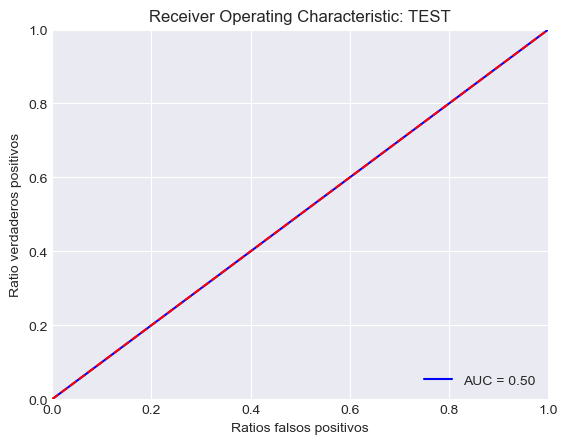

In [205]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic: TEST')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % svc_rbf_roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Ratio verdaderos positivos')
plt.xlabel('Ratios falsos positivos')
plt.show()

#### Consolidacion de los resultados del modelo SVC LINEAL

In [206]:
svc_rbf_resultados = {
    "cm": svc_rbf_cm_test.ravel().tolist(),
    "acc": round(svc_rbf_acc_test, 2),
    "roc_auc": round(svc_rbf_roc_auc_test, 2),
    "f1": round(svc_rbf_f1_test, 2),
    "precision": round(svc_rbf_precision_test, 2),
    "recall": round(svc_rbf_recall_test, 2),
    "costos_totales": int(svc_rbf_total_cost)
}

svc_lineal_resultados

{'cm': [72, 1, 8, 162],
 'acc': 0.96,
 'roc_auc': 0.97,
 'f1': 0.97,
 'precision': 0.99,
 'recall': 0.95,
 'costos_totales': 13}

## Cosolidación de todos los resultados de todos los modelos

In [226]:
# Consolidamos todos los diccionarios en una sola lista
list_results=[Rl_resultados,Dtc_resultados, rf_resultados, xgb_resultados,svc_lineal_resultados, svc_rbf_resultados, Nv_resultados]
df_results=pd.DataFrame(list_results)
df_results

,cm,acc,roc_auc,f1,precision,recall,costos_totales
0,"[72, 1, 7, 163]",0.97,0.97,0.98,0.99,0.96,12
1,"[73, 0, 6, 164]",0.98,0.98,0.98,1.00,0.96,10
2,"[72, 1, 6, 164]",0.97,0.98,0.98,0.99,0.96,11
3,"[73, 0, 2, 168]",0.99,0.99,0.99,1.00,0.99,2
4,"[72, 1, 8, 162]",0.96,0.97,0.97,0.99,0.95,13
5,"[73, 0, 170, 0]",0.30,0.50,0.00,0.00,0.00,170
6,"[72, 1, 5, 165]",0.98,0.98,0.98,0.99,0.97,10


In [227]:
df_results.index=["Regresión logistica", "Decision Tree", "Random Forrest", "XGB", "SVC_lineal", "SVC_rbf", "Naive Bayes"]
df_results.sort_values(by="costos_totales", ascending=True)

,cm,acc,roc_auc,f1,precision,recall,costos_totales
XGB,"[73, 0, 2, 168]",0.99,0.99,0.99,1.00,0.99,2
Decision Tree,"[73, 0, 6, 164]",0.98,0.98,0.98,1.00,0.96,10
Naive Bayes,"[72, 1, 5, 165]",0.98,0.98,0.98,0.99,0.97,10
Random Forrest,"[72, 1, 6, 164]",0.97,0.98,0.98,0.99,0.96,11
Regresión logistica,"[72, 1, 7, 163]",0.97,0.97,0.98,0.99,0.96,12
SVC_lineal,"[72, 1, 8, 162]",0.96,0.97,0.97,0.99,0.95,13
SVC_rbf,"[73, 0, 170, 0]",0.30,0.50,0.00,0.00,0.00,170


In [228]:
#### Exportar resumen de resultados en excel
df_results.to_csv("resultados_modelos.csv", index=False)